In [20]:
import torch
import torch.nn as nn
import numpy as nf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

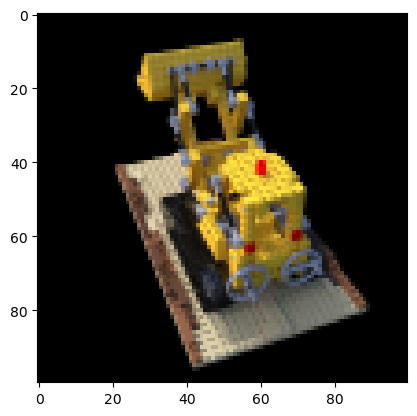

(106, 100, 100, 3)


In [21]:
# Load the data from the tiny nerf data set
data = np.load('./datasets/tiny_nerf_data.npz')
images, poses, focal = data['images'], data['poses'], data['focal']

height = np.shape(images)[1]
width = np.shape(images)[2]
# print(height)
# print(width)
# print(focal)
# print(np.shape(poses))
# plt.imshow(images[0])
plt.imshow(images[50])
plt.show()
print(np.shape(images))


![title](./images/positional_encoding.png)

In [26]:
#Positional encoding (p.g. 7 Section 5.1 of NERF Paper)
L_val=4
L_val=10

def positional_encoding(x):
    x_array = [x]
    for i in range(L_val):
        torch.append(x_array, torch.sin(2.0**i * x))
        torch.append(x_array, torch.cos(2.0**i * x))
    concat_x = torch.cat(x_array, -1)
    return concat_x   

def find_rays(width, height, focal, camera_frames):
    i, j = torch.meshgrid(torch.range(width), torch.range(height), indexing="xy")
    width_over_focal = (i-width/2.0)/focal
    height_over_focal = -1 * (j - height/ 2.0)/focal
    dirs = torch.stack([width_over_focal, height_over_focal, -1 * torch.ones_like(i)], -1)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = torch.expand(c2w[:3,-1], torch.shape(rays_d))
    return rays_o, rays_d

In [27]:
#Create the pytorch model
input_num = 2*3*L_val+3

class Nerf(nn.Module):
    def __init__(self, input_dim=input_num, output_dim=input_num, depth=8, nn_count=256):
        super(Nerf, self).__init__()
        self.depth = depth
        self.nn_count = nn_count
        
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.linears = nn.ModuleList([nn.Linear(input_dim, output_dim) for i in range(depth - 1)])
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        for i, layers in enumerate(self.linears):
            out = layers(out)
            out = self.sigmoid(out)
        return out

![title](./images/adam.png)